# Anomaly Detection using Audio
## 5. Calling the Azure CV model

<img src="soundanomaly.jpg">

<div class="alert alert-info"> <b>Let's predict an audio file.</b></div>

In [1]:
#!pip install azure-cognitiveservices-vision-customvision
#!pip install emoji
#!pip install python-docx
#!pip install pymsteams

In [2]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [3]:
import datetime
Current_Date = datetime.datetime.today()
print ('Current Date: ' + str(Current_Date))

Current Date: 2022-03-22 11:22:13.099132


In [32]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import os, time, uuid
import matplotlib.pyplot as plt
import numpy as np
import librosa, librosa.display, IPython.display as ipd
import emoji
import datetime
import docx
import pymsteams
import smtplib
from email.message import EmailMessage
import emoji
from configparser import ConfigParser
import plotly.graph_objects as go

## Customvision

In [5]:
# Retrieving the Azure customvision.ai deployed model information from the azurecvconfig.ini file
configcv = ConfigParser()
print (configcv.read('azurecvconfig.ini'))
print("Section:", configcv.sections())

PREDICTION_KEY = configcv.get('azurecustomvision', 'PREDICTION_KEY')
ENDPOINT = configcv.get('azurecustomvision', 'ENDPOINT')
PROJECT_ID = configcv.get('azurecustomvision', 'PROJECT_ID')
ITERATION_NAME = configcv.get('azurecustomvision', 'ITERATION_NAME')

['azurecvconfig.ini']
Section: ['azurecustomvision']


In [6]:
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY })
predictor = CustomVisionPredictionClient(ENDPOINT, credentials)

In [7]:
def AudioMetadata(audiofile):
    
    import os.path
    import time
    import audio_metadata
    
    lastmodifdate = time.ctime(os.path.getmtime(audiofile))
    creationdate = time.ctime(os.path.getctime(audiofile))
    audiofilemetadata = audio_metadata.load(audiofile)
    
    bitrate=audiofilemetadata['streaminfo']['bitrate']
    nbchannels=audiofilemetadata['streaminfo']['channels']
    duration=audiofilemetadata['streaminfo']['duration']
    samplerate=audiofilemetadata['streaminfo']['sample_rate']
    audiofilesize=audiofilemetadata['filesize']
    print("===== Audio Statistics =====\n")
    print("Audio File:\t", audiofile)
    print("Modified Date:\t", lastmodifdate)
    print("Creation Date:\t", creationdate)
    print("File Size:\t", audiofilesize)

    print("Bit Rate:\t", bitrate)
    print("Sampling Rate:\t", samplerate)
    print("Nb of Channels:\t", nbchannels)
    print("Duration:\t", duration)
    print()
    
    return { 'audiofile' : audiofile , 'lastmodifdate' : lastmodifdate,  'creationdate' : creationdate ,
             'audiofilesize' : audiofilesize ,   
             'bitrate' : bitrate , 'samplerate' : samplerate,  'nbchannels' : nbchannels , 'duration' : duration }

In [31]:
def gauge_report(VALUE, MSG):
    fig = go.Figure(go.Indicator(
        mode = "number+gauge+delta", value = VALUE,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {'text' : MSG},
        delta = {'reference': 0.5},
        gauge = {
            'shape': "bullet",
            'axis': {'range': [None, 1]},
            'bar' : {'color' : 'black', 'thickness' : 0.2 },
            'threshold': {'line': {'color': "blue", 'width': 4}, 'thickness': 1, 'value': 0.5},
            'steps': [
                {'range': [0, 0.5], 'color': "red"},
                {'range': [0.5, 0.6], 'color': "orange"},
                {'range': [0.6, 0.7], 'color': "mediumseagreen"},
                {'range': [0.7, 1], 'color': "green"}
            ]}))
    
    fig.update_layout(height = 250, width = 900)
    fig.show()

## Let's analyse a WAV audio file to predict its class

In [33]:
audiofile = 'test/machine_KO_57.wav'

In [34]:
AudioMetadata(audiofile)

===== Audio Statistics =====

Audio File:	 test/machine_KO_57.wav
Modified Date:	 Mon Mar 21 12:00:35 2022
Creation Date:	 Mon Mar 21 12:00:35 2022
File Size:	 1234844
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'test/machine_KO_57.wav',
 'lastmodifdate': 'Mon Mar 21 12:00:35 2022',
 'creationdate': 'Mon Mar 21 12:00:35 2022',
 'audiofilesize': 1234844,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

## Playing the sounds file

In [35]:
print("File is:", audiofile)
from IPython.display import Audio
Audio(audiofile)

File is: test/machine_KO_57.wav


In [36]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


Text(0, 0.5, 'Amplitude')

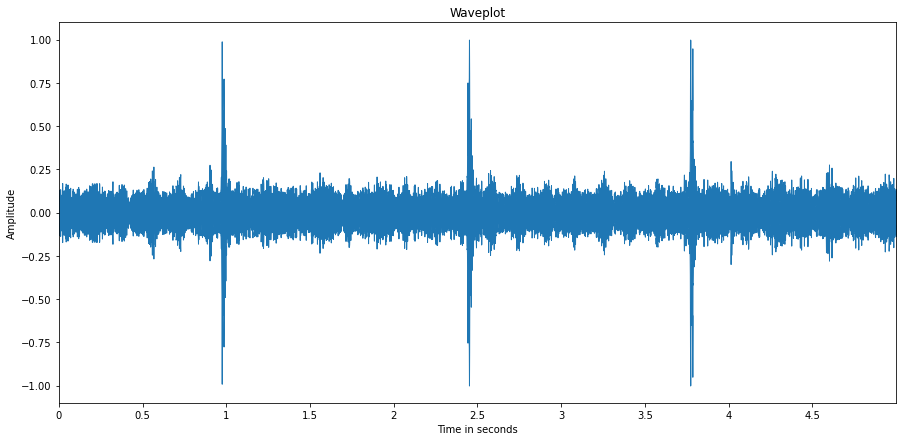

In [37]:
from librosa import display

plt.figure(figsize=(15,7))
librosa.display.waveplot(y=samples, sr=sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
#plt.savefig('results/signal.jpg')

In [38]:
y, sr = librosa.load(audiofile)
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print(tempo)

172.265625


## Periodogram

In [39]:
exportfile = 'test/spectogram.jpg'

In [40]:
durationsecs = 7
hoplength = 512
samprate = 44100
nfft = 2048

In [41]:
plt.figure(figsize=(15, 8))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
fig = plt.figure()
        
mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hoplength, n_fft=nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', hop_length=hoplength)
        
plt.ioff()
#fig = plt.figure()
        
plt.axis('off')
plt.savefig(exportfile, dpi = 400)
plt.close('all')

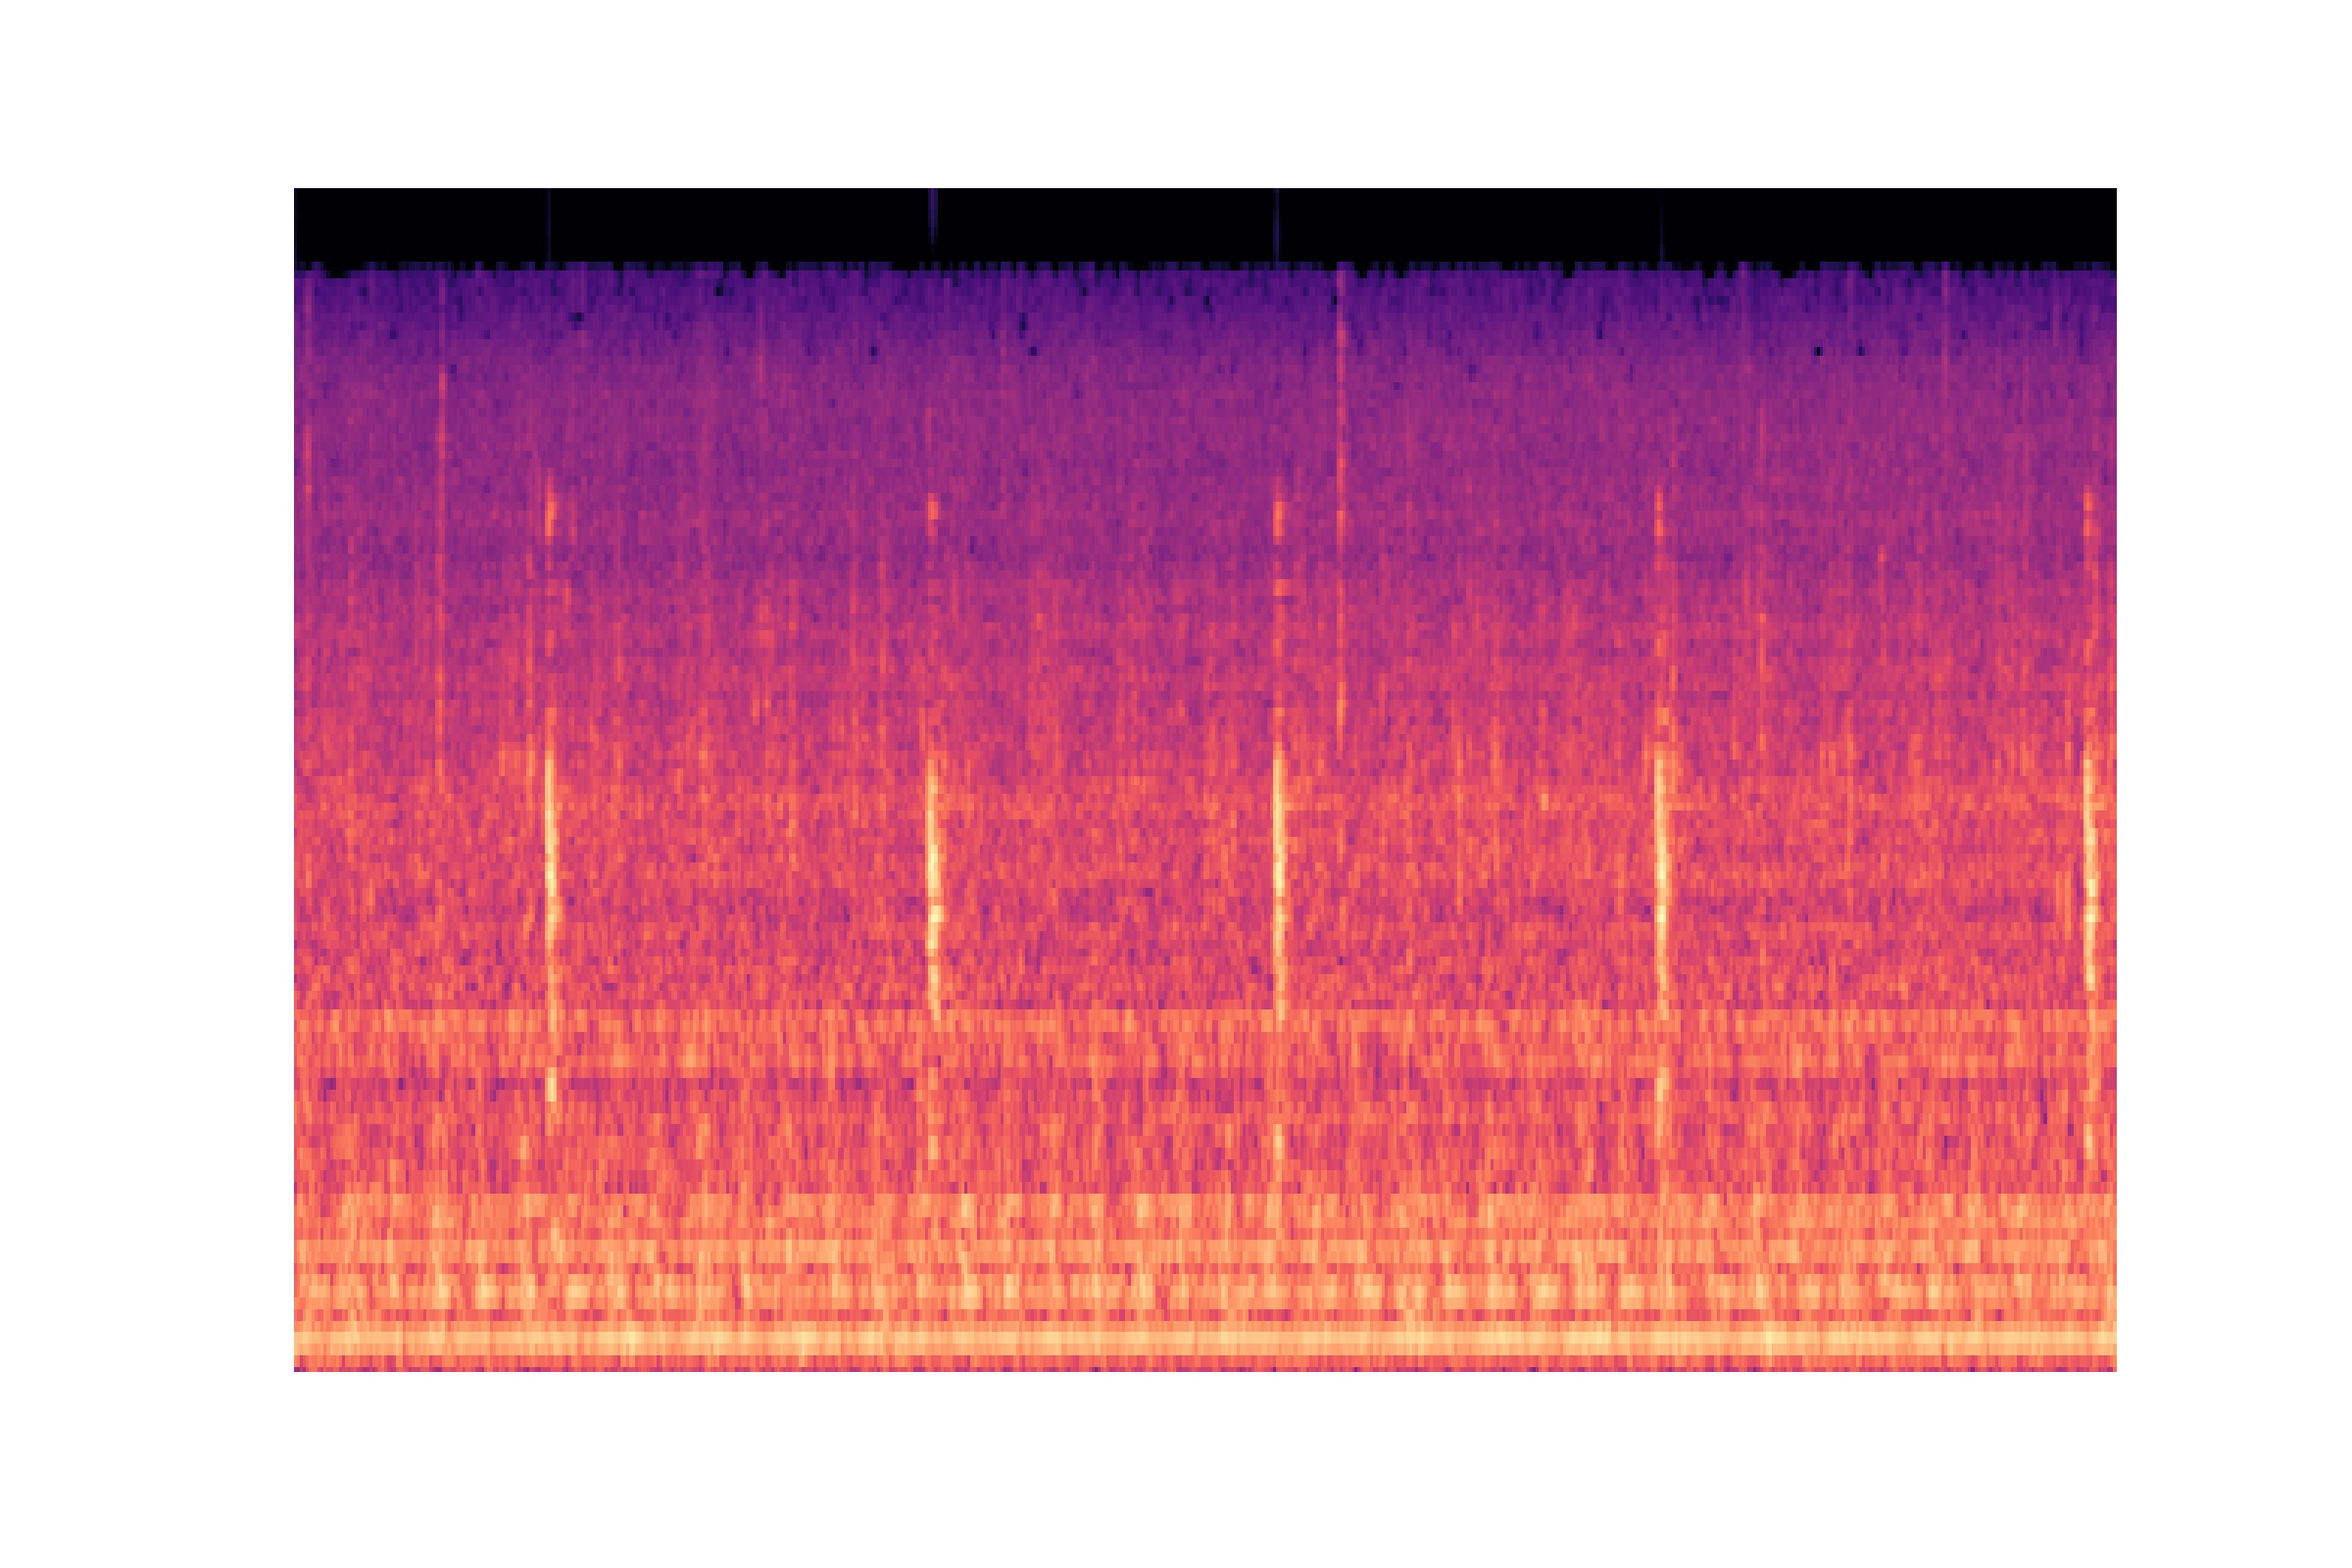

In [42]:
from IPython.display import Image
Image(filename=exportfile) 

## Calling the CV model

In [43]:
print("Prediction of", audiofile)

Prediction of test/machine_KO_57.wav


In [44]:
print(emoji.emojize("Calling the custom vision model to predict sound anomalies :thumbs_up:"))
print()
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

with open(os.path.join (exportfile), "rb") as image_contents:
    results = predictor.classify_image(PROJECT_ID, ITERATION_NAME , image_contents.read())

    for prediction in results.predictions:
        print("\033[1;31;34m-", prediction.tag_name, "\tConfidence =", round(prediction.probability, 5))

Calling the custom vision model to predict sound anomalies 👍

- KO 	Confidence = 0.99998
- OK 	Confidence = 2e-05


In [45]:
listeprob=[]
listetag = []

for prediction in results.predictions:
    listetag.append(prediction.tag_name)
    listeprob.append(prediction.probability)

now = datetime.datetime.today()
print(now)

prob_max = max(listeprob)
max_index = listeprob.index(prob_max)
max_tag = listetag[max_index]
probapct = round(prob_max * 100, 2)
decision = max_tag.upper()

if max_tag == "KO":
    print("\033[1;31;91m")
    msg = "[ALERT] A sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

if max_tag == "OK":
    print("\033[1;31;34m")
    msg = "[OK] No sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

2022-03-22 11:26:19.359925

[ALERT] A sound anomaly has been detected with a confidence of 100.0%


In [46]:
gauge_report(prob_max, max_tag)

## Another test

In [47]:
# This audio file do not contain a sound anomaly in it = OK
audiofile = 'test/machine_OK_57.wav'

In [48]:
AudioMetadata(audiofile)

===== Audio Statistics =====

Audio File:	 test/machine_OK_57.wav
Modified Date:	 Mon Mar 21 12:00:35 2022
Creation Date:	 Mon Mar 21 12:00:35 2022
File Size:	 1234844
Bit Rate:	 1411200
Sampling Rate:	 44100
Nb of Channels:	 2
Duration:	 7.0



{'audiofile': 'test/machine_OK_57.wav',
 'lastmodifdate': 'Mon Mar 21 12:00:35 2022',
 'creationdate': 'Mon Mar 21 12:00:35 2022',
 'audiofilesize': 1234844,
 'bitrate': 1411200,
 'samplerate': 44100,
 'nbchannels': 2,
 'duration': 7.0}

In [49]:
print("File is:", audiofile)
from IPython.display import Audio
Audio(audiofile)

File is: test/machine_OK_57.wav


In [50]:
samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = 5)
len(samples), sampling_rate
duration = len(samples) / sampling_rate
print("Samping rate:", sampling_rate)

Samping rate: 44100


Text(0, 0.5, 'Amplitude')

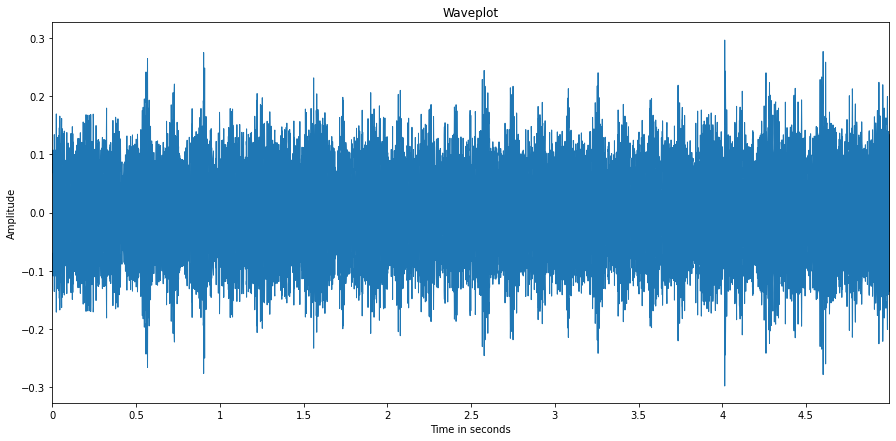

In [51]:
from librosa import display

plt.figure(figsize=(15,7))
librosa.display.waveplot(y=samples, sr=sampling_rate)
plt.title('Waveplot')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')
#plt.savefig('results/signal.jpg')

In [52]:
plt.figure(figsize=(15, 8))

y, sr = librosa.load(audiofile,  sr = None, mono = True, offset = 0.0, duration = durationsecs)
plt.ioff()
fig = plt.figure()

<Figure size 1080x576 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [53]:
mel_signal = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hoplength, n_fft=nfft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', hop_length=hoplength)
        
plt.ioff()
#fig = plt.figure()
        
plt.axis('off')
plt.savefig(exportfile, dpi = 400)
plt.close('all')

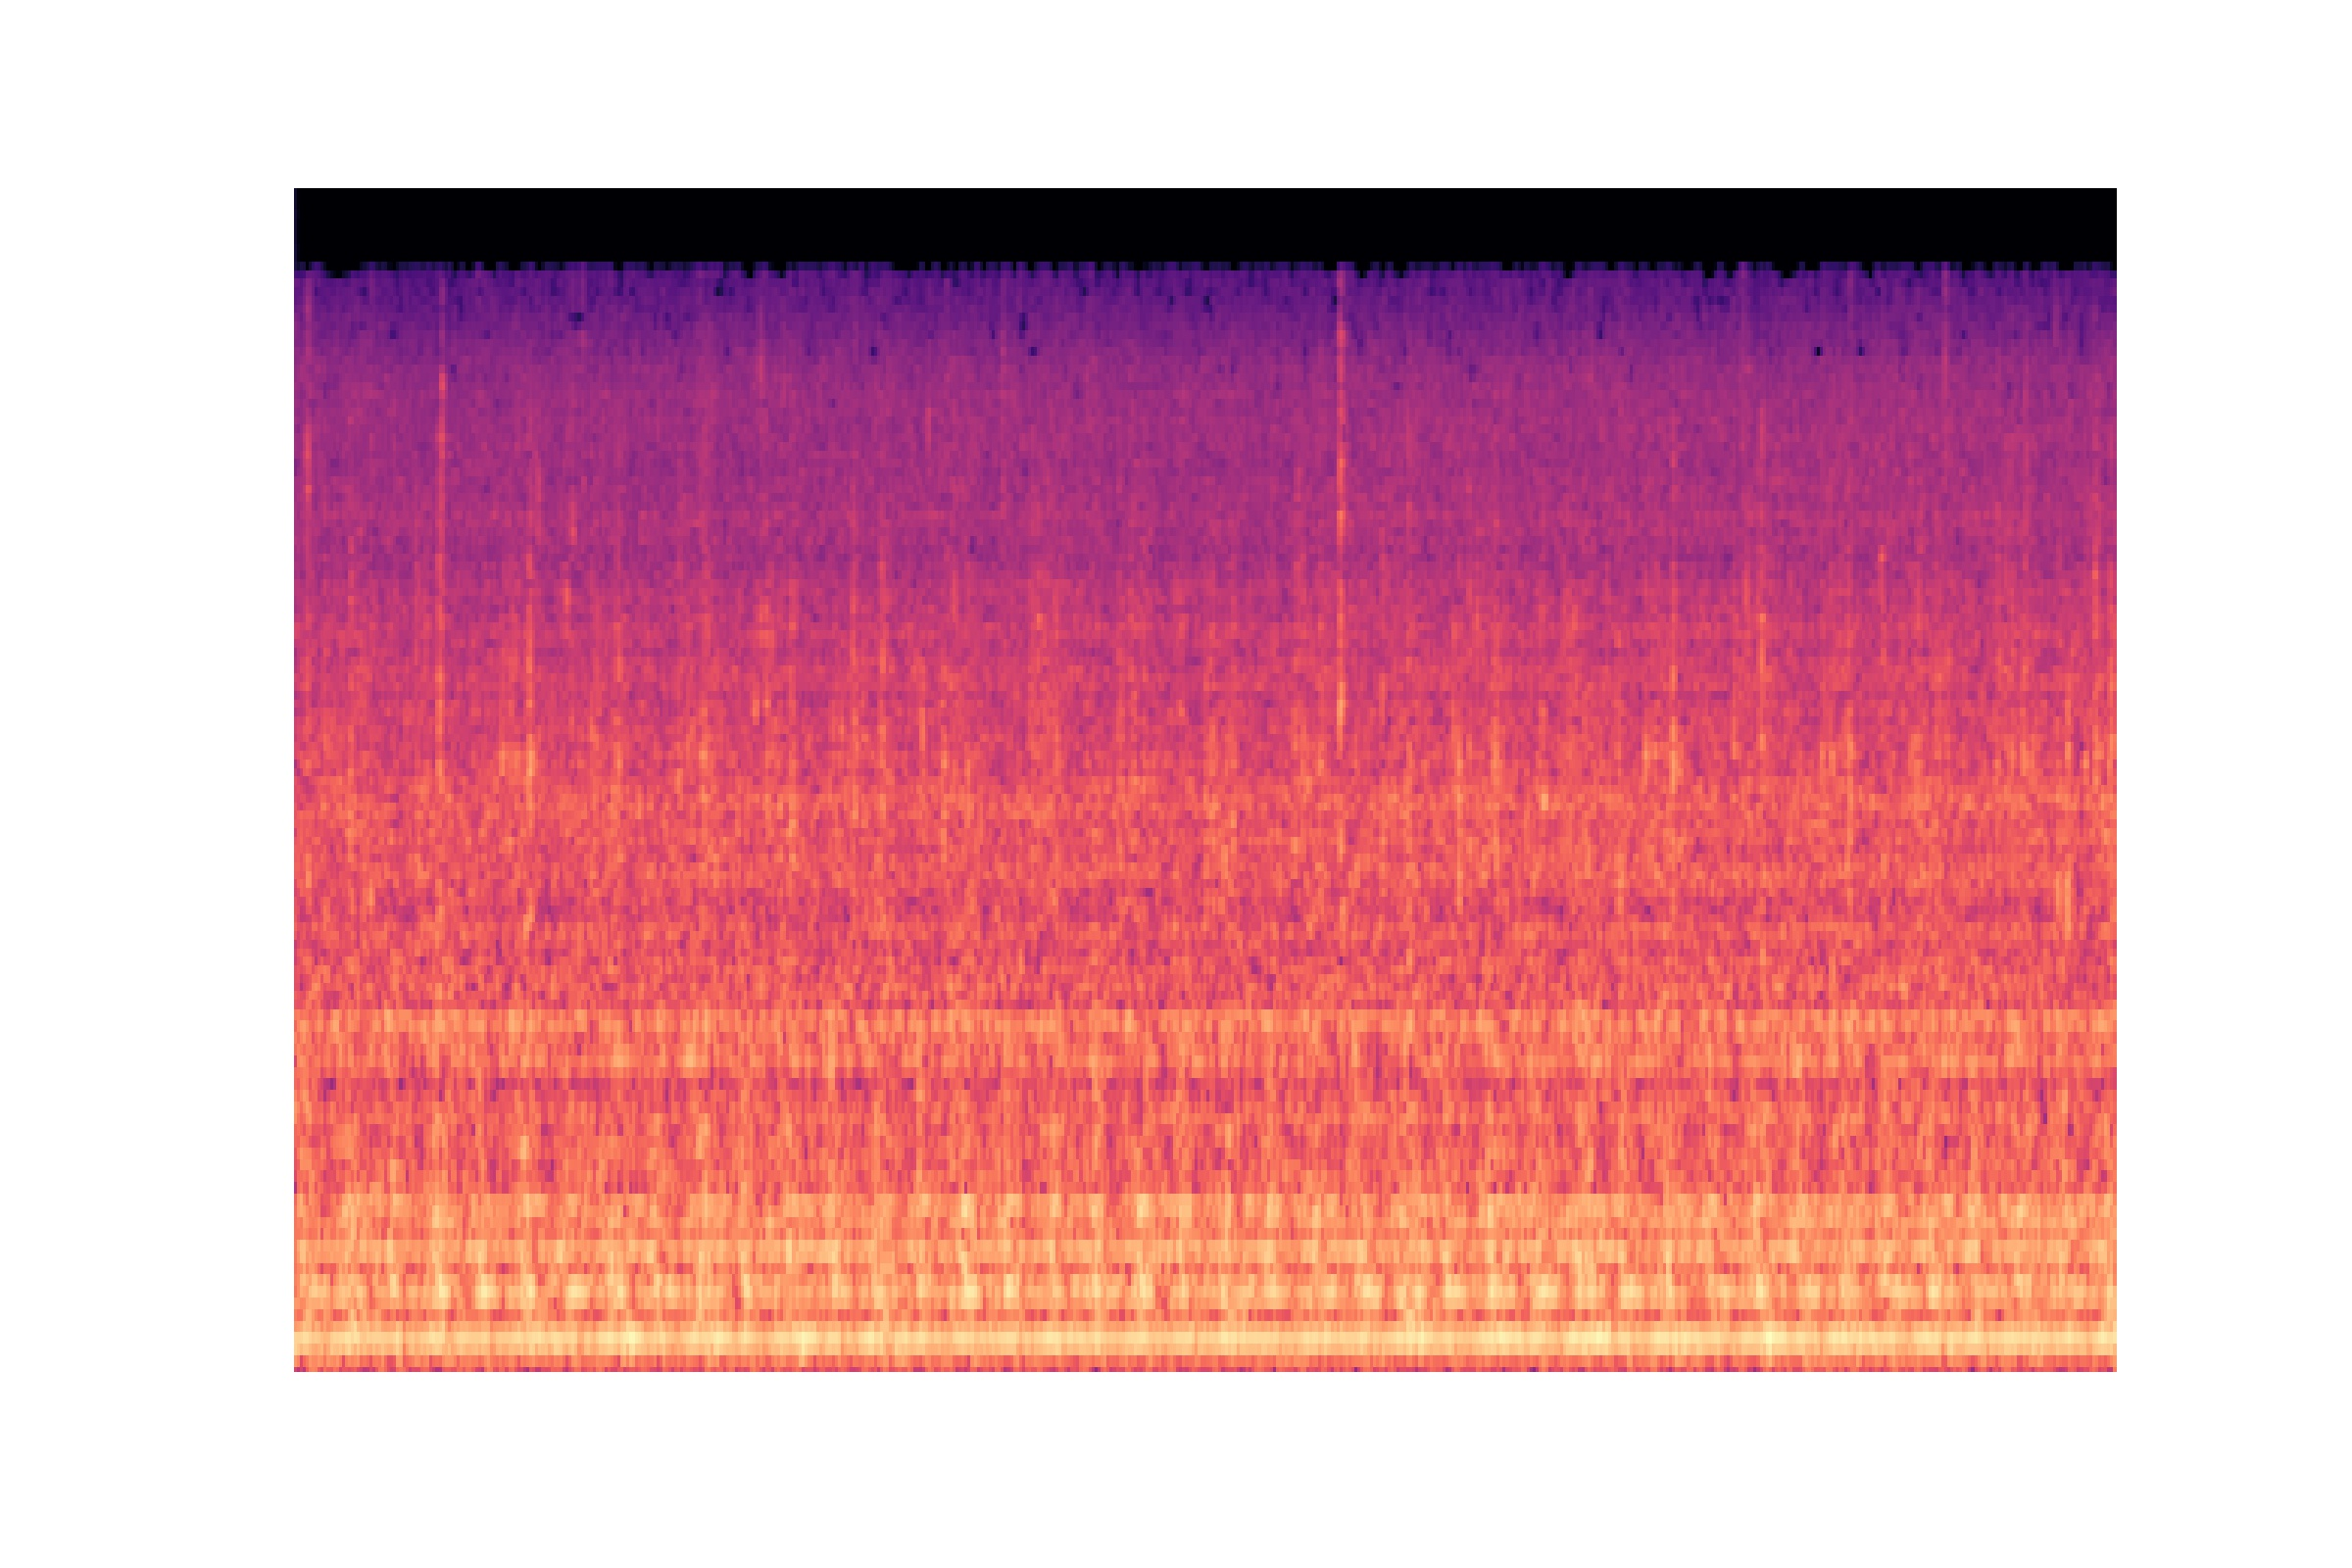

In [54]:
from IPython.display import Image
Image(filename=exportfile) 

In [55]:
print(emoji.emojize("Calling the custom vision model to predict sound anomalies :thumbs_up:"))
print()
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

with open(os.path.join (exportfile), "rb") as image_contents:
    results = predictor.classify_image(PROJECT_ID, ITERATION_NAME , image_contents.read())

    for prediction in results.predictions:
        print("\033[1;31;34m-", prediction.tag_name, "\tConfidence =", round(prediction.probability, 5))


Calling the custom vision model to predict sound anomalies 👍

- OK 	Confidence = 0.75896
- KO 	Confidence = 0.24104


In [56]:
listeprob=[]
listetag = []

for prediction in results.predictions:
    listetag.append(prediction.tag_name)
    listeprob.append(prediction.probability)

now = datetime.datetime.today()
print(now)

prob_max = max(listeprob)
max_index = listeprob.index(prob_max)
max_tag = listetag[max_index]
probapct = round(prob_max * 100, 2)
decision = max_tag.upper()

if max_tag == "KO":
    print("\033[1;31;91m")
    msg = "[ALERT] A sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

if max_tag == "OK":
    print("\033[1;31;34m")
    msg = "[OK] No sound anomaly has been detected with a confidence of " + str(probapct) + '%'
    print(msg)

2022-03-22 11:26:42.598351

[OK] No sound anomaly has been detected with a confidence of 75.9%


In [57]:
gauge_report(prob_max, max_tag)

> End